# 1. Import and Install Dependencies

In [ ]:
!pip install opencv-python
!pip install --upgrade pip
!pip install mediapipe
!pip install ultralytics
!pip install scikit-learn matplotlib

In [3]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Input
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import torch
from ultralytics import YOLO
from collections import deque

# 2. Keypoints using MP 

In [ ]:
#Initialize MediaPipe drawing utilities
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(
    static_image_mode=False,
    model_complexity=2,
    smooth_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.7
)

In [5]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def draw_landmarks(image, results):
    # Draw pose connections
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
            image,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),  # Green color for landmarks
            connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=2)  # Red color for connections
        )

def draw_styled_landmarks(image, results):
    # Draw pose connections with custom styling
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
            image,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing.DrawingSpec(color=(80, 22, 10), thickness=2, circle_radius=4),  # Custom landmark style
            connection_drawing_spec=mp_drawing.DrawingSpec(color=(80, 44, 121), thickness=2, circle_radius=2)  # Custom connection style
        )

# 3. Extract Keypoint Values

In [ ]:
def extract_keypoints(results):
    # Extract pose landmarks (33 keypoints, each with x, y, z, and visibility)
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33 * 4)
    return pose

# 4. Setup Folders for Collection

In [ ]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('your_folder') #path to save keyoints 

# Actions that we try to detect
actions = np.array(['front', 'hook', 'jab', 'roundhouse'])

# Sequence videos worth of data
no_sequences = 520

# Videos are going to be 60 frames in length
sequence_length = 60

# Define the folder containing action videos
VIDEO_PATH = ('your_dataset_folder')  # Root folder containing action videos (dataset folder)

!!! RUN ONLY WHEN EXTRACTING KEYPOINTS (FOLDERS CREATION) !!!

In [ ]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [ ]:
# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)


# Loop through each action (jab, hook, uppercut)
for action in actions:
    action_folder = os.path.join(VIDEO_PATH, action)  # Path to action videos

    # Loop through each video sequence (0-29)
    for sequence in range(no_sequences):
        video_path = os.path.join(action_folder, f"{sequence}.mp4")  
        
        # Debugging: Print path before checking
        print(f"Checking video: {video_path}")

        if not os.path.exists(video_path):
            print(f"⚠️ Skipping missing video: {video_path}")
            continue

        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            print(f"⚠️ Could not open {video_path} - Possible codec issue or corrupted file")
            continue

        frame_count = 0  # Initialize frame counter

        # Ensure output directories exist
        os.makedirs(os.path.join(DATA_PATH, action, str(sequence)), exist_ok=True)

        # Loop through frames (expecting 30 frames per video)
        for frame_num in range(sequence_length):
            ret, frame = cap.read()

            if not ret:
                print(f"⚠️ Frame {frame_num} missing in {video_path}, stopping early.")
                break  

            # Make detections
            image, results = mediapipe_detection(frame, pose)

            # Extract keypoints
            keypoints = extract_keypoints(results)

            # Save keypoints
            npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
            np.save(npy_path, keypoints)

            frame_count += 1  # Increment frame count

        cap.release()
        
        # Print the final frame count for verification
        print(f"✅ {video_path}: Extracted {frame_count}/30 frames")

# 6. Preprocess Data and Create Labels and Features

In [19]:
label_map = {label:num for num, label in enumerate(actions)}

In [20]:
label_map

{'front': 0, 'hook': 1, 'jab': 2, 'roundhouse': 3}

In [ ]:
sequences, labels = [], []
for action in actions:

    for sequence in [s for s in os.listdir(os.path.join(DATA_PATH, action)) if s.isdigit()]:
        sequence = int(sequence)
        window = []
    # Rest of your code
    
    #for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        #window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [ ]:
np.array(sequences).shape

In [ ]:
np.array(labels).shape

In [24]:
X = np.array(sequences)

In [ ]:
X.shape

In [ ]:
y = to_categorical(labels).astype(int)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
y_test.shape

# 7. Data Augmentation (Set-up)

In [ ]:
# Normalize data
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_reshaped).reshape(X_train.shape)
X_test = scaler.transform(X_test_reshaped).reshape(X_test.shape)

#Augmentation
def augment_keypoints(keypoints, noise_factor=0.01):
    noise = np.random.normal(0, noise_factor, keypoints.shape)
    return keypoints + noise

# Apply augmentation to the training data (in-memory only)
X_train_augmented = np.array([augment_keypoints(seq) for seq in X_train])

## 7.1 Adding Gaussian Noise

In [ ]:
!pip install opencv-python

In [ ]:
import os
import cv2
import torch
import numpy as np

# Define paths to your dataset folder and output folder
input_dir = "your_dataset_path"  # Replace with your dataset path
output_dir = "your_output_path"  # Replace with your output path
os.makedirs(output_dir, exist_ok=True)  # Create the output folder if it doesn't exist

# Function to add Gaussian noise to a video tensor
def add_gaussian_noise(video_tensor, mean=0, std=0.1):
    noise = torch.randn_like(video_tensor) * std + mean
    noisy_video = video_tensor + noise
    noisy_video = torch.clamp(noisy_video, 0, 1)  # Clip values to [0, 1]
    return noisy_video

# Function to randomly apply augmentations
def random_augment(video_tensor, augmentation_prob=0.5):
    if np.random.rand() < augmentation_prob:
        video_tensor = add_gaussian_noise(video_tensor)
    return video_tensor

# Function to save augmented videos
def save_augmented_video(video_tensor, output_path, fps=30):
    video_tensor = (video_tensor * 255).byte()  # Scale to [0, 255]
    video_tensor = video_tensor.permute(1, 2, 3, 0)  # (C, T, H, W) -> (T, H, W, C)
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Codec for .mp4 files
    height, width = video_tensor.shape[1:3]
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    for frame in video_tensor:
        out.write(frame.numpy())
    out.release()

# Function to load a video using OpenCV
def load_video_opencv(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        frame = torch.from_numpy(frame).float() / 255.0  # Normalize to [0, 1]
        frames.append(frame)
    cap.release()
    if len(frames) == 0:
        raise RuntimeError(f"No frames found in video: {video_path}")
    return torch.stack(frames).permute(3, 0, 1, 2)  # (T, H, W, C) -> (C, T, H, W)

# Recursively process videos in the dataset folder
for root, dirs, files in os.walk(input_dir):
    for file in files:
        # Skip non-video files (e.g., .DS_Store)
        if not file.lower().endswith((".mp4", ".avi", ".mov", ".mkv")):
            print(f"Skipping non-video file: {file}")
            continue
        
        # Construct full paths
        video_path = os.path.join(root, file)
        relative_path = os.path.relpath(root, input_dir)  # Get relative path to maintain folder structure
        output_subdir = os.path.join(output_dir, relative_path)
        os.makedirs(output_subdir, exist_ok=True)  # Create corresponding subfolder in output directory
        output_path = os.path.join(output_subdir, f"augmented_{file}")
        
        try:
            # Load video using OpenCV
            video_tensor = load_video_opencv(video_path)
            
            # Apply augmentation
            augmented_video = random_augment(video_tensor)
            
            # Save augmented video
            save_augmented_video(augmented_video, output_path)
            print(f"Saved augmented video: {output_path}")
        except Exception as e:
            print(f"Error processing {video_path}: {e}")

print("Data augmentation complete!")

## 7.2 Changing Background

In [ ]:
import os
import cv2
import torch
import numpy as np
import random

# Define paths to your dataset folder and output folder
input_dir = "your_dataset_path"  # Replace with your dataset path
output_dir = "your_output_path"  # Replace with your output path
background_path = "your_image_path"  # Path to your background image

# Debugging: Check if the background file exists
if not os.path.exists(background_path):
    raise FileNotFoundError(f"Background image not found at {background_path}. Please check the file path.")

# Load the background image
background = cv2.imread(background_path)
if background is None:
    raise ValueError(f"Failed to load background image at {background_path}. The file may be corrupted or not an image.")
background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
background = torch.from_numpy(background).float() / 255.0  # Normalize to [0, 1]

# Number of videos to augment
num_samples = 100

# Function to resize the background to match the frame size
def resize_background(background, frame_height, frame_width):
    """
    Resize the background image to match the frame dimensions.
    Args:
        background (torch.Tensor): Background image tensor of shape (H, W, C).
        frame_height (int): Height of the video frame.
        frame_width (int): Width of the video frame.
    Returns:
        torch.Tensor: Resized background tensor.
    """
    background = background.permute(2, 0, 1)  # (H, W, C) -> (C, H, W) for resizing
    background = torch.nn.functional.interpolate(
        background.unsqueeze(0),  # Add batch dimension
        size=(frame_height, frame_width),
        mode="bilinear",
        align_corners=False,
    ).squeeze(0)  # Remove batch dimension
    background = background.permute(1, 2, 0)  # (C, H, W) -> (H, W, C)
    return background

# Function to replace the background of a video frame
def replace_background(frame, background, threshold=30):
    """
    Replace the background of a frame using a simple background subtraction technique.
    Args:
        frame (torch.Tensor): Input frame tensor of shape (H, W, C).
        background (torch.Tensor): Background image tensor of shape (H, W, C).
        threshold (int): Threshold for background subtraction.
    Returns:
        torch.Tensor: Frame with the background replaced.
    """
    # Compute the absolute difference between the frame and the background
    diff = torch.abs(frame - background)
    mask = torch.mean(diff, dim=-1) > (threshold / 255.0)  # Create a mask for the foreground
    mask = mask.unsqueeze(-1).expand_as(frame)  # Expand mask to match frame dimensions
    
    # Replace the background
    result = torch.where(mask, frame, background)
    return result

# Function to save augmented videos
def save_augmented_video(video_tensor, output_path, fps=30):
    video_tensor = (video_tensor * 255).byte()  # Scale to [0, 255]
    video_tensor = video_tensor.permute(1, 2, 3, 0)  # (C, T, H, W) -> (T, H, W, C)
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Codec for .mp4 files
    height, width = video_tensor.shape[1:3]
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    for frame in video_tensor:
        out.write(frame.numpy())
    out.release()

# Function to load a video using OpenCV
def load_video_opencv(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        frame = torch.from_numpy(frame).float() / 255.0  # Normalize to [0, 1]
        frames.append(frame)
    cap.release()
    if len(frames) == 0:
        raise RuntimeError(f"No frames found in video: {video_path}")
    return torch.stack(frames).permute(3, 0, 1, 2)  # (T, H, W, C) -> (C, T, H, W)

# Collect all video paths in the dataset
video_paths = []
for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.lower().endswith((".mp4", ".avi", ".mov", ".mkv")):
            video_paths.append(os.path.join(root, file))

# Randomly select 100 videos
if len(video_paths) < num_samples:
    raise ValueError(f"Not enough videos in the dataset. Found {len(video_paths)} videos, but {num_samples} are required.")
selected_video_paths = random.sample(video_paths, num_samples)

# Process the selected videos
for video_path in selected_video_paths:
    try:
        # Load video using OpenCV
        video_tensor = load_video_opencv(video_path)
        
        # Get the frame dimensions
        _, _, frame_height, frame_width = video_tensor.shape
        
        # Resize the background to match the frame dimensions
        resized_background = resize_background(background, frame_height, frame_width)
        
        # Replace the background for each frame
        augmented_frames = []
        for frame in video_tensor.permute(1, 2, 3, 0):  # (C, T, H, W) -> (T, H, W, C)
            frame = replace_background(frame, resized_background)
            augmented_frames.append(frame)
        augmented_video = torch.stack(augmented_frames).permute(3, 0, 1, 2)  # (T, H, W, C) -> (C, T, H, W)
        
        # Construct output path
        relative_path = os.path.relpath(os.path.dirname(video_path), input_dir)  # Get relative path
        output_subdir = os.path.join(output_dir, relative_path)
        os.makedirs(output_subdir, exist_ok=True)  # Create corresponding subfolder in output directory
        output_file = f"augmented_{os.path.basename(video_path)}"
        output_path = os.path.join(output_subdir, output_file)
        
        # Save augmented video
        save_augmented_video(augmented_video, output_path)
        print(f"Saved augmented video: {output_path}")
    except Exception as e:
        print(f"Error processing {video_path}: {e}")

print("Data augmentation complete!")

## 7.3 Flipping and Rotating

In [ ]:
import os
import cv2
import torch
import numpy as np
import random
from math import cos, sin, radians

# Define paths to your dataset folder and output folder
input_dir = "your_dataset_path"  # Replace with your dataset path
output_dir = "your_output_path"  # Replace with your output path
os.makedirs(output_dir, exist_ok=True)  # Create the output folder if it doesn't exist

# Number of videos to augment
num_samples = 100

# Function to flip a video frame
def flip_frame(frame, flip_code):
    """
    Flip a video frame horizontally or vertically.
    Args:
        frame (torch.Tensor): Input frame tensor of shape (H, W, C).
        flip_code (int): 0 for vertical flip, 1 for horizontal flip.
    Returns:
        torch.Tensor: Flipped frame tensor.
    """
    return torch.from_numpy(cv2.flip(frame.numpy(), flip_code))

# Function to rotate a video frame
def rotate_frame(frame, angle):
    """
    Rotate a video frame by a given angle.
    Args:
        frame (torch.Tensor): Input frame tensor of shape (H, W, C).
        angle (float): Angle of rotation in degrees.
    Returns:
        torch.Tensor: Rotated frame tensor.
    """
    frame_np = frame.numpy()
    h, w = frame_np.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_frame = cv2.warpAffine(frame_np, rotation_matrix, (w, h))
    return torch.from_numpy(rotated_frame)

# Function to save augmented videos
def save_augmented_video(video_tensor, output_path, fps=30):
    video_tensor = (video_tensor * 255).byte()  # Scale to [0, 255]
    video_tensor = video_tensor.permute(1, 2, 3, 0)  # (C, T, H, W) -> (T, H, W, C)
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Codec for .mp4 files
    height, width = video_tensor.shape[1:3]
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    for frame in video_tensor:
        out.write(frame.numpy())
    out.release()

# Function to load a video using OpenCV
def load_video_opencv(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        frame = torch.from_numpy(frame).float() / 255.0  # Normalize to [0, 1]
        frames.append(frame)
    cap.release()
    if len(frames) == 0:
        raise RuntimeError(f"No frames found in video: {video_path}")
    return torch.stack(frames).permute(3, 0, 1, 2)  # (T, H, W, C) -> (C, T, H, W)

# Collect all video paths in the dataset
video_paths = []
for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.lower().endswith((".mp4", ".avi", ".mov", ".mkv")):
            video_paths.append(os.path.join(root, file))

# Randomly select 100 videos
if len(video_paths) < num_samples:
    raise ValueError(f"Not enough videos in the dataset. Found {len(video_paths)} videos, but {num_samples} are required.")
selected_video_paths = random.sample(video_paths, num_samples)

# Process the selected videos
for video_path in selected_video_paths:
    try:
        # Load video using OpenCV
        video_tensor = load_video_opencv(video_path)
        
        # Apply random flip and rotation to each frame
        augmented_frames = []
        flip_code = random.choice([0, 1])  # 0 = vertical flip, 1 = horizontal flip
        angle = random.uniform(-30, 30)  # Rotate between -30 and 30 degrees
        for frame in video_tensor.permute(1, 2, 3, 0):  # (C, T, H, W) -> (T, H, W, C)
            # Flip the frame
            frame = flip_frame(frame, flip_code)
            # Rotate the frame
            frame = rotate_frame(frame, angle)
            augmented_frames.append(frame)
        augmented_video = torch.stack(augmented_frames).permute(3, 0, 1, 2)  # (T, H, W, C) -> (C, T, H, W)
        
        # Construct output path
        relative_path = os.path.relpath(os.path.dirname(video_path), input_dir)  # Get relative path
        output_subdir = os.path.join(output_dir, relative_path)
        os.makedirs(output_subdir, exist_ok=True)  # Create corresponding subfolder in output directory
        output_file = f"augmented_{os.path.basename(video_path)}"
        output_path = os.path.join(output_subdir, output_file)
        
        # Save augmented video
        save_augmented_video(augmented_video, output_path)
        print(f"Saved augmented video: {output_path}")
    except Exception as e:
        print(f"Error processing {video_path}: {e}")

print("Data augmentation complete!")

In [ ]:
import os
import cv2
import torch
import numpy as np
import random
from math import cos, sin, radians

# Define paths to your dataset folder and output folder
input_dir = "your_dataset_path"  # Replace with your dataset path
output_dir = "your_output_path"  # Replace with your output path
os.makedirs(output_dir, exist_ok=True)  # Create the output folder if it doesn't exist

# Number of videos to augment per folder
num_samples_per_folder = 100

# Function to flip a video frame
def flip_frame(frame, flip_code):
    """
    Flip a video frame horizontally or vertically.
    Args:
        frame (torch.Tensor): Input frame tensor of shape (H, W, C).
        flip_code (int): 0 for vertical flip, 1 for horizontal flip.
    Returns:
        torch.Tensor: Flipped frame tensor.
    """
    return torch.from_numpy(cv2.flip(frame.numpy(), flip_code))

# Function to rotate a video frame
def rotate_frame(frame, angle):
    """
    Rotate a video frame by a given angle.
    Args:
        frame (torch.Tensor): Input frame tensor of shape (H, W, C).
        angle (float): Angle of rotation in degrees.
    Returns:
        torch.Tensor: Rotated frame tensor.
    """
    frame_np = frame.numpy()
    h, w = frame_np.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_frame = cv2.warpAffine(frame_np, rotation_matrix, (w, h))
    return torch.from_numpy(rotated_frame)

# Function to convert a frame to greenscale
def greenscale_frame(frame):
    """
    Convert a frame to greenscale by emphasizing the green channel.
    Args:
        frame (torch.Tensor): Input frame tensor of shape (H, W, C).
    Returns:
        torch.Tensor: Greenscale frame tensor.
    """
    frame_np = frame.numpy()
    # Emphasize the green channel
    frame_np[:, :, 0] = 0  # Set blue channel to 0
    frame_np[:, :, 2] = 0  # Set red channel to 0
    return torch.from_numpy(frame_np)

# Function to add grain to a frame
def add_grain(frame, intensity=0.2):
    """
    Add grain/noise to a frame.
    Args:
        frame (torch.Tensor): Input frame tensor of shape (H, W, C).
        intensity (float): Intensity of the grain (0 to 1).
    Returns:
        torch.Tensor: Grainy frame tensor.
    """
    noise = torch.randn_like(frame) * intensity
    grainy_frame = frame + noise
    grainy_frame = torch.clamp(grainy_frame, 0, 1)  # Clip values to [0, 1]
    return grainy_frame

# Function to save augmented videos
def save_augmented_video(video_tensor, output_path, fps=30):
    video_tensor = (video_tensor * 255).byte()  # Scale to [0, 255]
    video_tensor = video_tensor.permute(1, 2, 3, 0)  # (C, T, H, W) -> (T, H, W, C)
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Codec for .mp4 files
    height, width = video_tensor.shape[1:3]
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    for frame in video_tensor:
        out.write(frame.numpy())
    out.release()

# Function to load a video using OpenCV
def load_video_opencv(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        frame = torch.from_numpy(frame).float() / 255.0  # Normalize to [0, 1]
        frames.append(frame)
    cap.release()
    if len(frames) == 0:
        raise RuntimeError(f"No frames found in video: {video_path}")
    return torch.stack(frames).permute(3, 0, 1, 2)  # (T, H, W, C) -> (C, T, H, W)

# Collect all video paths in the dataset, grouped by folder
folder_video_paths = {}
for root, dirs, files in os.walk(input_dir):
    for dir_name in dirs:
        folder_path = os.path.join(root, dir_name)
        video_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.lower().endswith((".mp4", ".avi", ".mov", ".mkv"))]
        folder_video_paths[dir_name] = video_paths

# Process videos in each folder
for folder_name, video_paths in folder_video_paths.items():
    if len(video_paths) < num_samples_per_folder:
        print(f"Not enough videos in folder {folder_name}. Found {len(video_paths)} videos, but {num_samples_per_folder} are required.")
        continue
    
    # Randomly select 100 videos from the folder
    selected_video_paths = random.sample(video_paths, num_samples_per_folder)
    
    # Process the selected videos
    for video_path in selected_video_paths:
        try:
            # Load video using OpenCV
            video_tensor = load_video_opencv(video_path)
            
            # Apply random flip, rotation, greenscale, and grain to each frame
            augmented_frames = []
            flip_code = random.choice([0, 1])  # 0 = vertical flip, 1 = horizontal flip
            angle = random.uniform(-30, 30)  # Rotate between -30 and 30 degrees
            for frame in video_tensor.permute(1, 2, 3, 0):  # (C, T, H, W) -> (T, H, W, C)
                # Flip the frame
                frame = flip_frame(frame, flip_code)
                # Rotate the frame
                frame = rotate_frame(frame, angle)
                # Convert to greenscale
                frame = greenscale_frame(frame)
                # Add grain
                frame = add_grain(frame, intensity=0.1)
                augmented_frames.append(frame)
            augmented_video = torch.stack(augmented_frames).permute(3, 0, 1, 2)  # (T, H, W, C) -> (C, T, H, W)
            
            # Construct output path
            relative_path = os.path.relpath(os.path.dirname(video_path), input_dir)  # Get relative path
            output_subdir = os.path.join(output_dir, relative_path)
            os.makedirs(output_subdir, exist_ok=True)  # Create corresponding subfolder in output directory
            output_file = f"augmented_{os.path.basename(video_path)}"
            output_path = os.path.join(output_subdir, output_file)
            
            # Save augmented video
            save_augmented_video(augmented_video, output_path)
            print(f"Saved augmented video: {output_path}")
        except Exception as e:
            print(f"Error processing {video_path}: {e}")

print("Data augmentation complete!")

# 8. Build and Train Neural Network

In [15]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

## 8.1 1D-CNN (CONV1D)

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

# Define the CNN-only model architecture
model = models.Sequential([
    layers.Input(shape=(60, 132)),
    
    # Normalization & Augmentation
    layers.BatchNormalization(),
    layers.GaussianNoise(0.01),  # Small noise for robustness
    
    # Feature extraction with Conv1D layers
    layers.Conv1D(filters=256, kernel_size=7, padding='same'),
    layers.LeakyReLU(alpha=0.1),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),
    
    # Additional Conv1D layers for deeper feature extraction
    layers.Conv1D(filters=512, kernel_size=5, padding='same'),
    layers.LeakyReLU(alpha=0.1),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),
    
    layers.Conv1D(filters=256, kernel_size=3, padding='same'),
    layers.LeakyReLU(alpha=0.1),
    layers.GlobalMaxPooling1D(),
    
    # Fully Connected layers
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

# Compile with tuned learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003, clipnorm=1.0),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define additional callbacks for improved training
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
model_checkpoint = ModelCheckpoint('best_cnn_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
tb_callback = TensorBoard(log_dir='./logs_cnn')
callbacks = [tb_callback, early_stopping, reduce_lr, model_checkpoint]

# Train the model using the existing augmented data
history = model.fit(X_train, y_train,
                    epochs=100,
                    validation_split=0.2,
                    batch_size=16,  # Increased batch size for better stability
                    callbacks=callbacks)

## 8.2 LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

# Define the LSTM-only model architecture
model = models.Sequential([
    layers.Input(shape=(60, 132)),
    
    # Normalization & Augmentation
    layers.BatchNormalization(),
    layers.GaussianNoise(0.01),  # Small noise for robustness
    
    # LSTM layers for sequence learning
    layers.LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
    layers.LSTM(512, return_sequences=False, dropout=0.3, recurrent_dropout=0.3),
    
    # Fully Connected layers
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

# Compile with tuned learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003, clipnorm=1.0),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define additional callbacks for improved training
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
model_checkpoint = ModelCheckpoint('best_lstm_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
tb_callback = TensorBoard(log_dir='./logs_lstm')
callbacks = [tb_callback, early_stopping, reduce_lr, model_checkpoint]

# Train the model using the existing augmented data
history = model.fit(X_train, y_train,
                    epochs=100,
                    validation_split=0.2,
                    batch_size=16,  # Increased batch size for better stability
                    callbacks=callbacks
                   )

# 9. Performance Metrics

## 9.1 1D-CNN

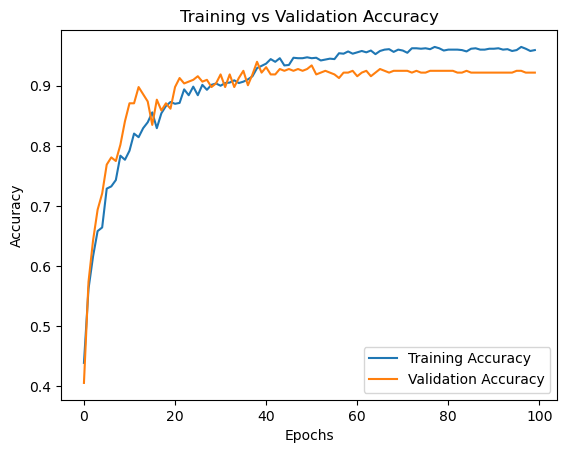

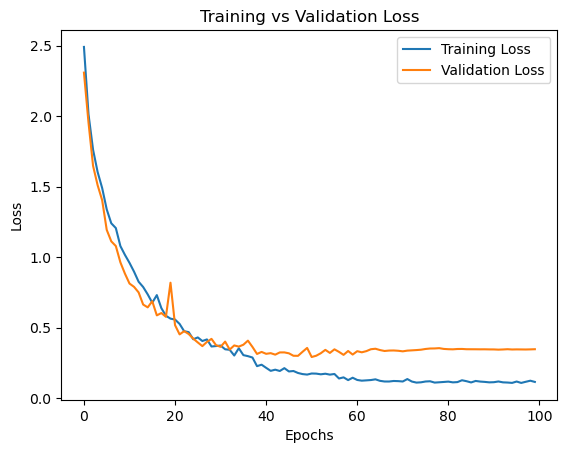

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step


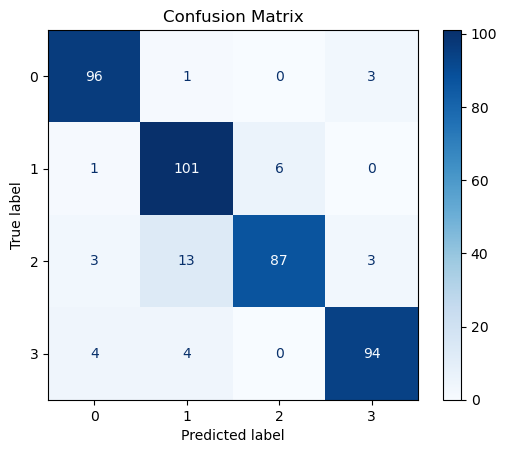

Top-1 Accuracy: 0.9087
Precision: 0.9118
Recall: 0.9094
F1 Score: 0.9090
Mean Average Precision (mAP): 0.9736


In [151]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, average_precision_score
)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

# Model predictions
yhat_probs = model.predict(X_test)  # Get probability predictions
ytrue = np.argmax(y_test, axis=1)   # Convert one-hot to integer labels
yhat = np.argmax(yhat_probs, axis=1)  # Get top-1 predicted class

# Confusion Matrix
cm = confusion_matrix(ytrue, yhat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Performance Metrics
top1_accuracy = accuracy_score(ytrue, yhat)  # Top-1 Accuracy (same as accuracy)
precision = precision_score(ytrue, yhat, average='macro')  
recall = recall_score(ytrue, yhat, average='macro')  
f1 = f1_score(ytrue, yhat, average='macro')  

# Mean Average Precision (mAP)
map_score = average_precision_score(y_test, yhat_probs, average='macro')  

# Print metrics
print(f"Top-1 Accuracy: {top1_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Mean Average Precision (mAP): {map_score:.4f}")

## 9.2 LSTM

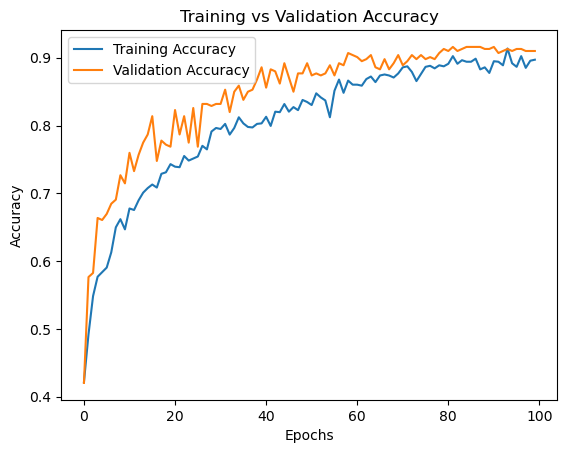

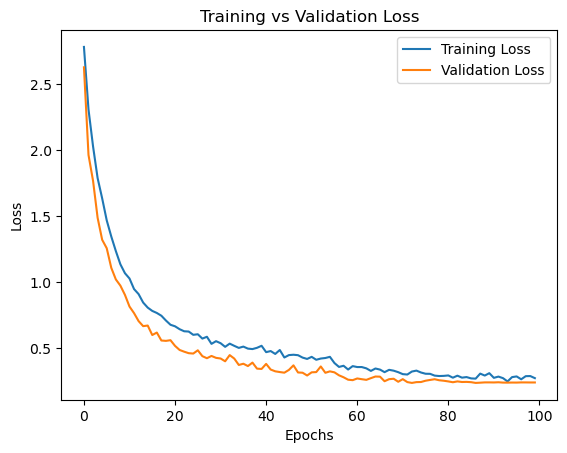

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step


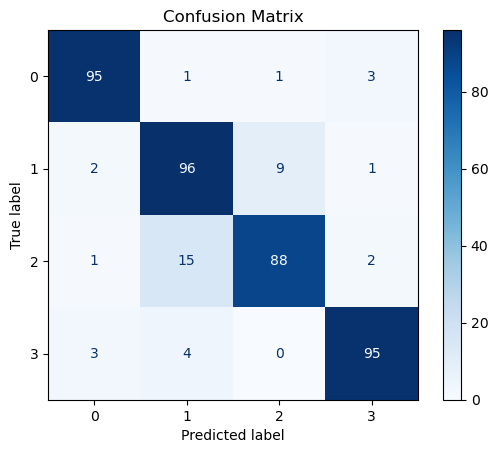

Top-1 Accuracy: 0.8990
Precision: 0.9017
Recall: 0.9001
F1 Score: 0.9003
Mean Average Precision (mAP): 0.9701


In [165]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, average_precision_score
)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

# Model predictions
yhat_probs = model.predict(X_test)  # Get probability predictions
ytrue = np.argmax(y_test, axis=1)   # Convert one-hot to integer labels
yhat = np.argmax(yhat_probs, axis=1)  # Get top-1 predicted class

# Confusion Matrix
cm = confusion_matrix(ytrue, yhat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Performance Metrics
top1_accuracy = accuracy_score(ytrue, yhat)  # Top-1 Accuracy (same as accuracy)
precision = precision_score(ytrue, yhat, average='macro')  
recall = recall_score(ytrue, yhat, average='macro')  
f1 = f1_score(ytrue, yhat, average='macro')  

# Mean Average Precision (mAP)
map_score = average_precision_score(y_test, yhat_probs, average='macro')  

# Print metrics
print(f"Top-1 Accuracy: {top1_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Mean Average Precision (mAP): {map_score:.4f}")

# 10. Make Predictions

In [ ]:
res = model.predict(X_test)

In [167]:
actions[np.argmax(res[4])]

'front'

In [168]:
actions[np.argmax(y_test[4])]

'front'

In [169]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [170]:
yhat = model.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step


In [171]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
accuracy_score(ytrue, yhat)

# 11. Save Weights

In [ ]:
model.save('put_your_model_name_here.h5')

In [ ]:
del model

In [ ]:
model.load_weights('best_cnn_model.keras') #replace with the name of your model

# 12. Test in Real Time

In [173]:
from scipy import stats

In [174]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [ ]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

## 12.1 Single Person OpenCV 

In [ ]:
# Set video path
video_path = r"your_video_path"  # Replace with your video path
# Load video
cap = cv2.VideoCapture(video_path)

# Initialize Mediapipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.8

# Main loop
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("End of video or error reading frame.")
        break

    # Convert BGR to RGB
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False

    # Pose detection
    results = pose.process(image)

    # Convert back to BGR
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Draw landmarks
    draw_landmarks(image, results)

    # Extract keypoints
    keypoints = extract_keypoints(results)
    sequence.append(keypoints)
    sequence = sequence[-60:]

    # Prediction logic
    if len(sequence) == 60:
        res = model.predict(np.expand_dims(sequence, axis=0))[0]
        print(actions[np.argmax(res)])
        predictions.append(np.argmax(res))

        # Visualization logic
        if np.unique(predictions[-10:])[0] == np.argmax(res):
            if res[np.argmax(res)] > threshold:
                if len(sentence) == 0 or actions[np.argmax(res)] != sentence[-1]:
                    sentence.append(actions[np.argmax(res)])

        if len(sentence) > 5:
            sentence = sentence[-5:]

    # Display results
    cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
    cv2.putText(image, ' '.join(sentence), (3, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    # Resize and show frame
    image = cv2.resize(image, (640, 480))
    cv2.imshow('Video Feed', image)

    # Press 'q' to exit
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
roundhouse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
roundhouse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
roundhouse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
roundhouse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
roundhouse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
roundhouse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
roundhouse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
roundhouse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
roundhouse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
roundhouse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
roundhouse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
roundhouse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
roundhouse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
roundhouse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
roundhouse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
roundhouse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
roundhouse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
roundhouse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
roundhouse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
roundhouse
1/1 ━━━━━━━━━━━━━━━━

## 12.2 Multiple Persons using YOLO

In [ ]:
import cv2
import numpy as np
import mediapipe as mp
from ultralytics import YOLO
from collections import deque
import certifi
import os

os.environ['SSL_CERT_FILE'] = certifi.where()

# Constants
actions = ['front', 'hook', 'jab', 'roundhouse']  # List of actions
threshold = 0.6  # Confidence threshold for predictions
window_size = 60  # Number of frames to average predictions over

# Colors for each fighter
fighter_colors = [(0, 255, 0), (0, 0, 255)]  # Green for fighter 0, Red for fighter 1

# Initialize MediaPipe Pose and drawing utilities
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(
    static_image_mode=False,
    model_complexity=2,
    smooth_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.7
)

def letterbox(im, new_shape=(256, 256), color=(0, 0, 0)):
    shape = im.shape[:2]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    new_unpad = (int(shape[1] * r), int(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]

    dw /= 2
    dh /= 2

    if shape[::-1] != new_unpad:
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(dh - 0.1), int(dh + 0.1)
    left, right = int(dw - 0.1), int(dw + 0.1)
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return im, r, (dw, dh)

# Initialize YOLO model
yolo_model = YOLO("yolov8n.pt") # Load YOLOv8 model

# Initialize FighterTracker
class FighterTracker:
    def __init__(self, max_disappeared=10):
        self.trackers = {}
        self.next_id = 0
        self.max_disappeared = max_disappeared
        self.fighter_ids = []

    def update(self, detections):
        active_ids = list(self.trackers.keys())

        # Sort detections by size (area) and keep top 2
        sorted_detections = sorted(detections,
                                 key=lambda d: (d[2]-d[0])*(d[3]-d[1]),
                                 reverse=True)[:2]

        for det in sorted_detections:
            x1, y1, x2, y2 = det[:4]
            centroid = ((x1 + x2)/2, (y1 + y2)/2)

            min_dist = float('inf')
            match_id = None

            # Only match with existing fighters
            for pid in self.fighter_ids:
                if pid not in self.trackers:
                    continue
                last_centroid = self.trackers[pid]['centroid']
                dist = np.linalg.norm(np.array(centroid) - np.array(last_centroid))
                if dist < min_dist and dist < 100:
                    min_dist = dist
                    match_id = pid

            if match_id is not None:
                self.trackers[match_id] = {
                    'bbox': (x1, y1, x2, y2),
                    'centroid': centroid,
                    'disappeared': 0
                }
            else:
                # Only create new tracks if under 2 fighters
                if len(self.fighter_ids) < 2:
                    self.trackers[self.next_id] = {
                        'bbox': (x1, y1, x2, y2),
                        'centroid': centroid,
                        'disappeared': 0
                    }
                    self.fighter_ids.append(self.next_id)
                    self.next_id += 1

        # Update fighter IDs list
        self.fighter_ids = [pid for pid in self.fighter_ids
                          if pid in self.trackers and
                          self.trackers[pid]['disappeared'] < self.max_disappeared]

        # Update disappeared counters
        for pid in list(self.trackers.keys()):
            if pid not in self.fighter_ids:
                self.trackers[pid]['disappeared'] += 1
                if self.trackers[pid]['disappeared'] > self.max_disappeared:
                    del self.trackers[pid]

# Initialize PoseSmoother
class PoseSmoother:
    def __init__(self, alpha=0.4, max_history=5):
        self.alpha = alpha
        self.history = deque(maxlen=max_history)

    def smooth_landmarks(self, landmarks):
        current = [(lmk.x, lmk.y, lmk.z, lmk.visibility) for lmk in landmarks]

        if not self.history:
            self.history.extend([current] * self.history.maxlen)
            return current

        prev = self.history[-1]
        smoothed = []
        for i in range(len(current)):
            sx = current[i][0] * self.alpha + prev[i][0] * (1 - self.alpha)
            sy = current[i][1] * self.alpha + prev[i][1] * (1 - self.alpha)
            sz = current[i][2] * self.alpha + prev[i][2] * (1 - self.alpha)
            sv = current[i][3]
            smoothed.append((sx, sy, sz, sv))

        self.history.append(smoothed)
        return smoothed

# Initialize components
tracker = FighterTracker()
smoothers = {}
action_counters = {pid: {action: 0 for action in actions} for pid in range(2)}  # Separate counters for each fighter
sequences = {pid: [] for pid in range(2)}  # Separate sequences for each fighter
predictions = {pid: [] for pid in range(2)}  # Separate predictions for each fighter
sentences = {pid: [] for pid in range(2)}  # Separate sentences for each fighter
last_action = {pid: None for pid in range(2)}  # Track the last detected action for each fighter

# Video processing
input_video_path = "your_video_path"  # Replace with your video path
cap = cv2.VideoCapture(input_video_path)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = int(cap.get(cv2.CAP_PROP_FPS))
output_video_path = "your_output_path"  # Replace with your output path
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Detect persons with higher confidence
    results = yolo_model(frame)
    detections = results[0].boxes.data.cpu().numpy()
    person_detections = [det for det in detections if int(det[5]) == 0 and det[4] > 0.8]
    
    # Update tracker with only top 2 largest persons
    tracker.update(person_detections)

    # Only process the two fighters
    for pid in tracker.fighter_ids:
        if pid not in tracker.trackers:
            continue

        data = tracker.trackers[pid]
        x1, y1, x2, y2 = data['bbox']

        if pid not in smoothers:
            smoothers[pid] = PoseSmoother(alpha=0.3, max_history=5)

        original_crop = frame[int(y1):int(y2), int(x1):int(x2)]
        if original_crop.size == 0:
            continue
            
        resized_crop, ratio, (dw, dh) = letterbox(original_crop)
        rgb_crop = cv2.cvtColor(resized_crop, cv2.COLOR_BGR2RGB)
        pose_results = pose.process(rgb_crop)

        if pose_results.pose_landmarks:
            
            smoothed = smoothers[pid].smooth_landmarks(pose_results.pose_landmarks.landmark)

            # Draw keypoints
            for connection in mp_pose.POSE_CONNECTIONS:
                start, end = connection
                lmk_start = smoothed[start]
                lmk_end = smoothed[end]

                def transform(coords):
                    x = (coords[0] * 256 - dw) / ratio + x1
                    y = (coords[1] * 256 - dh) / ratio + y1
                    return (int(x), int(y))

                pt1 = transform(lmk_start)
                pt2 = transform(lmk_end)

                if lmk_start[3] > 0.3 and lmk_end[3] > 0.3:
                    cv2.line(frame, pt1, pt2, fighter_colors[pid], 2)
                    cv2.circle(frame, pt1, 3, fighter_colors[pid], -1)
                    cv2.circle(frame, pt2, 3, fighter_colors[pid], -1)

        # Draw fighter box and ID
        cv2.putText(frame, f"Fighter {pid}", (int(x1), int(y1)-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, fighter_colors[pid], 2)
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), fighter_colors[pid], 3)

        # Action recognition logic
        keypoints = extract_keypoints(pose_results)  # Define this function to extract keypoints
        sequences[pid].append(keypoints)
        sequences[pid] = sequences[pid][-60:]  # Keep only the last 60 frames

        if len(sequences[pid]) == 60:
            res = model.predict(np.expand_dims(sequences[pid], axis=0))[0]
            predicted_action = actions[np.argmax(res)]
            predictions[pid].append(np.argmax(res))

            # Visualization logic
            if np.unique(predictions[pid][-10:])[0] == np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    if len(sentences[pid]) > 0: 
                        if actions[np.argmax(res)] != sentences[pid][-1]:
                            sentences[pid].append(actions[np.argmax(res)])
                            # Increment counter only if the action has changed
                            if last_action[pid] != predicted_action:
                                action_counters[pid][predicted_action] += 1
                                last_action[pid] = predicted_action
                    else:
                        sentences[pid].append(actions[np.argmax(res)])
                        # Increment counter for the first action
                        if last_action[pid] != predicted_action:
                            action_counters[pid][predicted_action] += 1
                            last_action[pid] = predicted_action

            if len(sentences[pid]) > 5: 
                sentences[pid] = sentences[pid][-5:]

    # Display results

    for pid in tracker.fighter_ids:
        if pid == 0:
            x_offset = 10  # Top-left corner for fighter 0
        else:
            x_offset = frame_width - 125  # Top-right corner for fighter 1
    
        y_offset = 70
    
        # Display counters
        for action, count in action_counters[pid].items():
            cv2.putText(frame, f'{action}: {count}', (x_offset, y_offset), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, fighter_colors[pid], 1, cv2.LINE_AA)  # Smaller font
            y_offset += 30
    
        # Display predicted sentence vertically below the counters with black outline
        for i, action in enumerate(sentences[pid]):
            text_position = (x_offset, y_offset + 40 + i * 30)
            
            # Draw black outline
            cv2.putText(frame, action, text_position, 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 3, cv2.LINE_AA)  # Black outline (thicker)
            
            # Draw white text
            cv2.putText(frame, action, text_position, 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)  # White text (thinner)

    # Write frame to output video
    out.write(frame)


# Release resources
cap.release()
out.release()

# Print final counts
for pid in range(2):
    print(f'Fighter {pid} counts:')
    for action, count in action_counters[pid].items():
        print(f'Total {action}: {count}')

I0000 00:00:1743528614.748784 3279502 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
100%|██████████████████████████████████████| 6.25M/6.25M [00:00<00:00, 13.2MB/s]



0: 384x640 5 persons, 72.4ms
Speed: 5.3ms preprocess, 72.4ms inference, 8.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 53.0ms
Speed: 1.3ms preprocess, 53.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


/Users/zaynabkhan/myenv/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '



0: 384x640 4 persons, 51.9ms
Speed: 1.1ms preprocess, 51.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 44.9ms
Speed: 1.1ms preprocess, 44.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 47.7ms
Speed: 1.1ms preprocess, 47.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 44.9ms
Speed: 1.1ms preprocess, 44.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 51.2ms
Speed: 3.7ms preprocess, 51.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 43.6ms
Speed: 1.6ms preprocess, 43.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 45.6ms
Speed: 1.1ms preprocess, 45.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 44.4ms
Speed: 1.2ms preprocess, 44.4ms inference, 0.5ms postprocess per image at shape (